In [ ]:
!pip install tfx==0.30.0

In [67]:
import tensorflow as tf

from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Transform

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from google.protobuf.json_format import MessageToDict

import os
import pprint

pp = pprint.PrettyPrinter()

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# location of the pipeline metadata store
_pipeline_root = 'pipeline/'



In [70]:
base_dir='data-centric/data_centric_pipeline/'
train_data_dir = base_dir+'dvc/data-centric-AI-competition/data/train/'
val_data_dir = base_dir+'dvc/data-centric-AI-competition/data/val/'
test_data_dir = base_dir+'dvc/data-centric-AI-competition/data/label_book/'
cnv = 'convert/'

# Converter
## images -> tfrecord

In [71]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to(images, label, path):
  
  labels = {1:"i", 2:"ii", 3:"iii", 4:"iv", 5:"v", 6:"vi", 7:"vii", 8:"viii", 9:"ix", 10:"x"}
  num_examples=len(images)

  filename = os.path.join(path+cnv+ labels[label] + '.tfrecords')
  print('Writing', filename)
  writer = tf.io.TFRecordWriter(filename)
  for index in range(num_examples):
    image_raw = open(path+f'{labels[label]}/'+images[index],'rb').read()
    image_shape = tf.io.decode_jpeg(image_raw).shape
    width = image_shape[0]
    height = image_shape[1]
    depth = image_shape[2]

    example = tf.train.Example(features=tf.train.Features(feature={
      
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())

In [72]:
labels = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
print(labels)

['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']


In [73]:
def convert_to_tfrecords(target):
  for index in range(len(labels)):
      files = [name for name in os.listdir(target+labels[index])]
      if '.DS_Store' in files:
        files.remove('.DS_Store')
      print('target:',labels[index])
      print(files)
      convert_to(files,index+1,target)


In [ ]:
convert_to_tfrecords(val_data_dir)

In [ ]:
convert_to_tfrecords(train_data_dir)

# End of util

## Interactive context below,,

In [76]:
context = InteractiveContext(pipeline_root=_pipeline_root)

In [77]:
import tensorflow as tf
import tfx
from tfx.components import ImportExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Transform
from tfx.proto import example_gen_pb2

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from google.protobuf.json_format import MessageToDict

from tfx.types.component_spec import ChannelParameter
from tfx.types.component_spec import ExecutionParameter
from tfx.types import artifact_utils
from tfx.types import standard_artifacts
from tfx.components.base import base_component
from tfx.components.base import base_executor
from tfx.components.base import executor_spec

import os
import pprint


In [78]:
input_split = example_gen_pb2.Input(splits=[
        example_gen_pb2.Input.Split(name='train', pattern='train/convert/*'),
        example_gen_pb2.Input.Split(name='val', pattern='val/convert/*')
    ])

example_gen = ImportExampleGen(input_base=base_dir, input_config=input_split)

In [79]:
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 26
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 48
        type_id: 5
        uri: "pipeline/ImportExampleGen/examples/26"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"val\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:train,num_files:10,total_bytes:833719,xor_checksum:101,sum_checksum:16246049911\nsplit:val,num_files:10,total_bytes:256154,xor_checksum:395,sum_checksum:16246044625"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [80]:
try:

    artifact = example_gen.outputs['examples'].get()[0]
    
    print(f'split names: {artifact.split_names}')
    print(f'artifact uri: {artifact.uri}')

except IndexError:
    print("context.run() was no-op")

else:
    artifact_uri = artifact.uri

split names: ["train", "val"]
artifact uri: pipeline/ImportExampleGen/examples/26


In [81]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(artifact_uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]
print(tfrecord_filenames)

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

['pipeline/ImportExampleGen/examples/26/Split-train/data_tfrecord-00000-of-00001.gz']


In [82]:
import sys
sys.path.append('/content/drive/MyDrive/data_centric')

In [83]:
import IPython.display as display
import convert

<MapDataset shapes: {image_raw: (), label: ()}, types: {image_raw: tf.string, label: tf.int64}>
tf.Tensor(1, shape=(), dtype=int64)


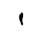

tf.Tensor(1, shape=(), dtype=int64)


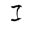

tf.Tensor(1, shape=(), dtype=int64)


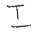

In [84]:


def get_records(dataset, num_records):

    raw_image_dataset = dataset.take(num_records)

    # Create a dictionary describing the features.
    image_feature_description = {

        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_image_function(example_proto):
      # Parse the input tf.train.Example proto using the dictionary above.
      return tf.io.parse_single_example(example_proto, image_feature_description)
    
    return raw_image_dataset.map(_parse_image_function)

parsed_image_dataset = get_records(dataset,3)

print(parsed_image_dataset)
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  print(image_features['label'])
  display.display(display.Image(data=image_raw))

In [85]:

# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
    

# Run the component
context.run(statistics_gen)


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 27
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 49
        type_id: 7
        uri: "pipeline/StatisticsGen/statistics/27"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"val\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [86]:
# Plot the statistics generated
context.show(statistics_gen.outputs['statistics'])

In [88]:

# Instantiate SchemaGen with the output statistics from the StatisticsGen
schema_gen = SchemaGen(statistics=statistics_gen.outputs['statistics'])
    
    

# Run the component
context.run(schema_gen)


ExecutionResult(
    component_id: SchemaGen
    execution_id: 28
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 50
        type_id: 9
        uri: "pipeline/SchemaGen/schema/28"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 9
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [89]:
# Visualize the output
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image_raw',BYTES,required,,-
'label',INT,required,,-


In [90]:
### START CODE HERE
# Instantiate ExampleValidator with the statistics and schema from the previous steps
example_validator = ExampleValidator(statistics=statistics_gen.outputs['statistics'],schema=schema_gen.outputs['schema'])
    
    

# Run the component
context.run(example_validator)
### END CODE HERE

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 29
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 51
        type_id: 11
        uri: "pipeline/ExampleValidator/anomalies/29"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"val\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 11
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [91]:
# Visualize the output
context.show(example_validator.outputs['anomalies'])

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:217: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [150]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 4.7MB/s 


In [152]:
import os
import tempfile
import urllib

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
keras = tf.keras
K = keras.backend

import apache_beam as beam

import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds
import tensorflow_model_analysis as tfma
from tensorflow_model_analysis.eval_saved_model.export import build_parsing_eval_input_receiver_fn

from tensorflow_addons.image import rotate

import tfx

from tfx.components.base import base_component
from tfx.components.base import base_executor
from tfx.components.base import executor_spec
from tfx.components.evaluator.component import Evaluator
from tfx.components.example_gen.import_example_gen.component import ImportExampleGen
from tfx.components.example_validator.component import ExampleValidator
from tfx.components.model_validator.component import ModelValidator
from tfx.components.pusher.component import Pusher
from tfx.components.schema_gen.component import SchemaGen
from tfx.components.statistics_gen.component import StatisticsGen
from tfx.components.trainer.component import Trainer
from tfx.components.transform.component import Transform

from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.beam.beam_dag_runner import BeamDagRunner
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

from tfx.types import artifact_utils
from tfx.types import standard_artifacts
from tfx.types.component_spec import ChannelParameter
from tfx.types.component_spec import ExecutionParameter


from tfx.proto import evaluator_pb2
from tfx.proto import example_gen_pb2
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2

from tensorflow_metadata.proto.v0 import schema_pb2

In [92]:
import sys
sys.path.append('/content/drive/MyDrive/data_centric')
# Set up paths.
_transform_module_file = 'tranform_module.py'

In [93]:
%%writefile {_transform_module_file}

import tensorflow_transform as tft
import tensorflow as tf

IMAGE_KEY = 'image_raw'
LABEL_KEY = 'label'
IMAGE_SIZE = 32

def transformed_name(name):
  return name + '_xf'

def _image_parser(image_str):
    image = tf.image.decode_image(image_str, channels=3)
    image = tf.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
    image = tf.cast(image, tf.float32) / 255.
    return image

def _label_parser(label_id):
    label = tf.one_hot(label_id, 10)
    return label

def preprocessing_fn(inputs):
    outputs = {transformed_name(IMAGE_KEY): tf.compat.v2.map_fn(_image_parser, tf.squeeze(inputs[IMAGE_KEY], axis=1),
                                                                  dtype=tf.float32),
               transformed_name(LABEL_KEY): tf.compat.v2.map_fn(_label_parser, tf.squeeze(inputs[LABEL_KEY], axis=1),
                                                                  dtype=tf.float32)
               }
    return outputs


Overwriting tranform_module.py


In [94]:
tf.get_logger().setLevel('ERROR')

transform = Transform(examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))
    

# Run the component.
# The `enable_cache` flag is disabled in case you need to update your transform module file.
context.run(transform, enable_cache=False)
### END CODE HERE

ERROR:absl:udf_utils.get_fn {'module_file': None, 'module_path': 'tranform_module@pipeline/_wheels/tfx_user_code_Transform-0.0+bc443b443803fcf8269be0e093051eba289d5ad0e88c6ccd653acafa0e271a78-py3-none-any.whl', 'preprocessing_fn': None} 'preprocessing_fn'


ExecutionResult(
    component_id: Transform
    execution_id: 30
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 52
        type_id: 13
        uri: "pipeline/Transform/transform_graph/30"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 53
        type_id: 5
        uri: "pipeline/Transform/transformed_examples/30"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"val\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 54
        type_id: 14
        uri: "pipeline/Transform/updated_analyzer_cache/30"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.30.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))